## Problem Statement

##### Customer churn leads to direct revenue loss in subscription-based businesses.
##### The goal is to predict customers who are likely to churn so that proactive
##### retention strategies can be implemented.
##### Business Focus:
##### - Missing a churner (False Negative) is costly
##### - Therefore, Recall and ROC-AUC are prioritized over Accuracy

### Importing Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    recall_score,
    roc_auc_score
)

from imblearn.over_sampling import SMOTE

### Load Dataset

In [16]:
df = pd.read_csv("churn.csv") 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Dataset Overview

In [17]:
df.shape
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Data Cleaning

In [18]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

C:\Users\aruni\AppData\Local\Temp\ipykernel_2408\3132022612.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


### Exploratory Data Analysis(EDA)

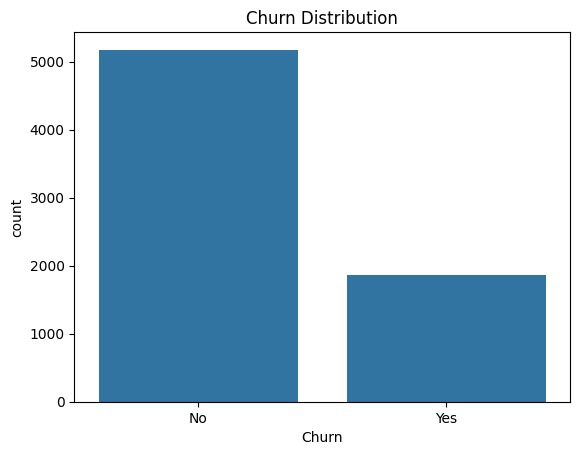

In [19]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

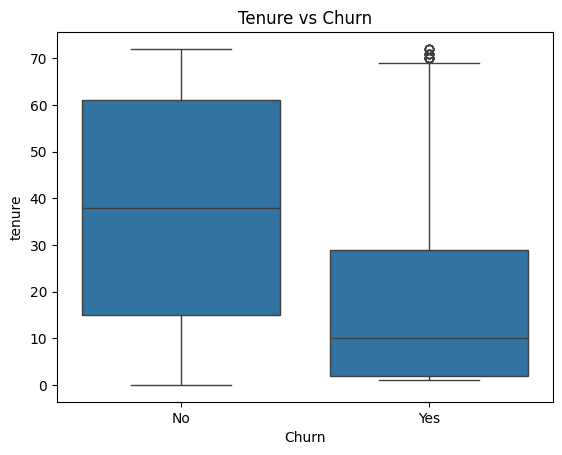

In [20]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()

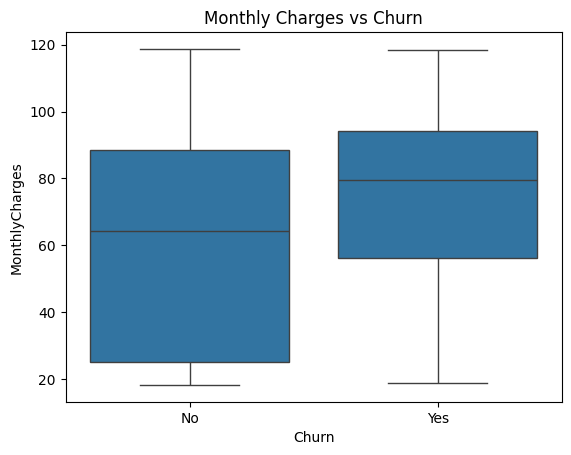

In [21]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

### Feature Engineering(One-Hot Encoding)

In [22]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0,45,42.30,1840.75,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True


### Train-Test Split

In [23]:
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

### Feature Scaling

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Handle Class Imbalance(SMOTE)

In [25]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

### Logistic Regression Model

In [26]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sm, y_train_sm)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("LOGISTIC REGRESSION")
print("Recall:", recall_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION
Recall: 0.7965738758029979
ROC-AUC: 0.8451310446170597
[[948 346]
 [ 95 372]]
              precision    recall  f1-score   support

       False       0.91      0.73      0.81      1294
        True       0.52      0.80      0.63       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.81      0.75      0.76      1761



### Threshold Tuning(Business Optimization)

In [27]:
y_pred_custom = (y_prob_lr > 0.35).astype(int)

print("Custom Threshold (0.35)")
print("Recall:", recall_score(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

Custom Threshold (0.35)
Recall: 0.8972162740899358
[[792 502]
 [ 48 419]]


### Random Forest Model

In [28]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("RANDOM FOREST")
print("Recall:", recall_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

RANDOM FOREST
Recall: 0.6038543897216274
ROC-AUC: 0.827834114956528


### Feature Importance(Churn Drivers)

In [29]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.head(10)

,Feature,Importance
1,tenure,0.153375
3,TotalCharges,0.139141
2,MonthlyCharges,0.124798
25,Contract_Two year,0.060902
28,PaymentMethod_Electronic check,0.047265
10,InternetService_Fiber optic,0.045454
13,OnlineSecurity_Yes,0.040616
26,PaperlessBilling_Yes,0.038018
24,Contract_One year,0.035641
19,TechSupport_Yes,0.031253


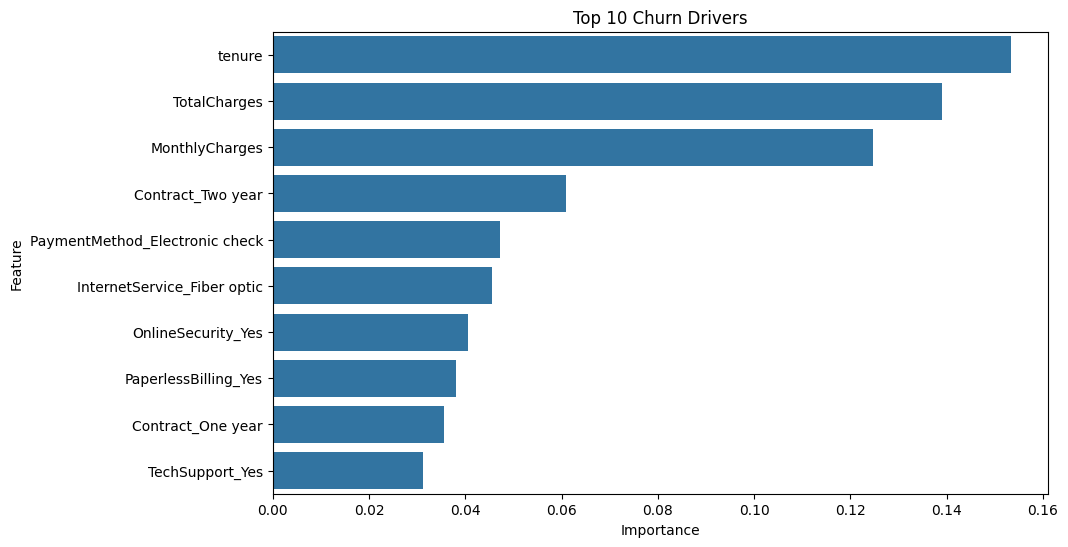

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance.head(10)
)
plt.title("Top 10 Churn Drivers")
plt.show()


## Conclusion

##### This project demonstrates how machine learning can support business
##### decision-making by identifying customers at risk of churn and enabling
##### targeted retention strategies.
